In [1]:
!pip install statsmodels=='0.13.2'

     |████████████████████████████████| 9.8 MB 8.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import statsmodels as sts
sts.__version__

'0.13.2'

### **Fontes de pesquisa:**
> **GitHub** 
- Criando Previsões de Preços para 5 dias Adiante: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Criando%20Previso%CC%83es%20de%20Prec%CC%A7os%20para%205%20dias%20Adiante.ipynb
- Criando Previsões de Séries Temporais: https://github.com/leandrovrabelo/tsmodels/blob/master/notebooks/portugues/Princi%CC%81pios%20Ba%CC%81sicos%20para%20Prever%20Se%CC%81ries%20Temporais.ipynb

> **YouTube**
- Prevendo Dados com Janelas Deslizantes usando Python: https://www.youtube.com/watch?v=J_ak48BA4RM&t=204s
- Prevendo Vendas com ARIMA - Passo a Passo com Python: https://www.youtube.com/watch?v=v7rZpT8NCbk&t=351s
- Séries temporais com Python: https://www.youtube.com/watch?v=1m9u10eJ3Mk&t=1824s

> **Kaggle** 
- Time Series For beginners with ARIMA: https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima
- Bitcoin Price. Prediction by ARIMA: https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima
- ARIMA Model for Time Series Forecasting: https://www.kaggle.com/prashant111/arima-model-for-time-series-forecasting
- Everything you can do with a time series: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
- AR, ARIMA, LSTM: https://www.kaggle.com/bogdanbaraban/ar-arima-lstm

> **Artigos** 
- Dicas para criar um modelo de previsão de séries temporais: https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148
- Identificação de um modelo ARIMA(p,d,q): https://www.midomenech.com.br/identificacao-de-um-modelo-arimapdq/
- Take Time-Series a Level-Up with Walk-Forward Validation: https://sarit-maitra.medium.com/take-time-series-a-level-up-with-walk-forward-validation-217c33114f68
- Forecasting with ARIMA Using Python: https://levelup.gitconnected.com/simple-forecasting-with-auto-arima-python-a3f651271965
- A Guide to Time Series Forecasting with ARIMA in Python 3: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-4-parameter-selection-for-the-arima-time-series-model
- ARIMA Model – Complete Guide to Time Series Forecasting in Python: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- Métodos de previsão de séries temporais em python e R: https://datapeaker.com/big-data/lenguajes-de-ciencia-de-datos-en-2020/

In [3]:
#importando bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, mean_absolute_percentage_error

%matplotlib notebook
%matplotlib inline
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/dataset_macau.csv')
# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo a coluna "Data" em datetime
df.Data = pd.to_datetime(df.Data)

# Tranformando a coluna "Data" em index
df.set_index('Data', inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,Velocidade,Temperatura,Umidade,Pressão,Direção
Data,,,,,
2004-01-01,6.33,29.13,67.67,1010.97,11.00
2004-01-02,4.63,29.47,70.33,1010.67,5.67
2004-01-03,5.47,29.00,73.00,1010.20,7.67
2004-01-04,7.97,30.00,70.00,1009.57,10.67
2004-01-05,6.73,29.60,67.67,1009.03,11.00


# AJUSTE DOS MODELOS

### Criando a previsão dentro da amostra

In [5]:
def predict_data(data, params):
    model = ARIMA(data, order=params)
    model_fit = model.fit()
    if params[1] == 0:
        pred = model_fit.predict()
    else:
        pred = model_fit.predict(typ='levels')
    return pred, model_fit

### Plotando os resultados da previsão

In [6]:
def plot_predict_data(orig, pred, start, end):
    plt.plot(orig[start:end],label='Original')
    plt.plot(pred[start:end],'--',label='Previsão')
    plt.title("Previsão dentro da amostra da velocidade do vento - Macau")
    plt.legend()
    plt.show()
    print("MSE : {:.5f}".format(mean_squared_error(pred.values, orig.values)))
    print("RMSE: {:.5f}".format(np.sqrt(mean_squared_error(pred.values, orig.values))))
    print("MAE : {:.5f}".format(mean_absolute_error(pred.values, orig.values)))
    print("MAPE: {:.5f}".format(mean_absolute_percentage_error(pred.values, orig.values)))

## **Previsão In Of Sample**

In [7]:
data = df.Velocidade
start,end=[len(data)-70,len(data)]

### Modelos obtidos com [Pesquisa em Grade]

> ORDER (9,0,7) => [TESTE ANTIGO]

In [ ]:
pred_old_gs, model_fit_old_gs = predict_data(data,(9,0,7))

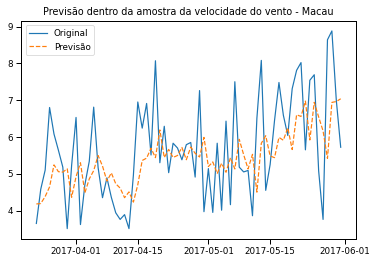

MSE : 1.05266
RMSE: 1.02599
MAE : 0.81500
MAPE: 0.16435


In [ ]:
plot_predict_data(data,pred_old_gs,start,end)

> ORDER (12,0,11) => [SEM DIFERENCIAÇÃO];
MSE : 1.04334
***RMSE: 1.02144***
MAE : 0.80806
MAPE: 0.16265

> ORDER (23,0,25) => [SEM DIFERENCIAÇÃO];
MSE : 1.03599
***RMSE: 1.01784***
MAE : 0.80815
MAPE: 0.16324

In [13]:
pred_gs1, model_fit_gs1 = predict_data(data,(23,0,25))

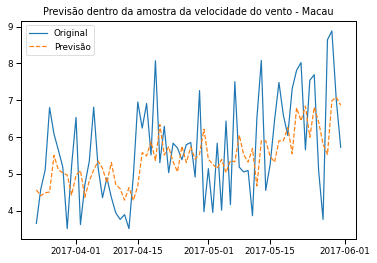

MSE : 1.03599
RMSE: 1.01784
MAE : 0.80815
MAPE: 0.16324


In [14]:
plot_predict_data(data,pred_gs1,start,end)

> ORDER (13,3,12) => [COM DIFIERENCIAÇÃO] (INVIESADO)

> ORDER (8,4,8) => [COM DIFIERENCIAÇÃO]; 
MSE : 1.28214
***RMSE: 1.13232***
MAE : 0.88233
MAPE: 5817915436991.06543

In [12]:
pred_gs2,model_fit_gs2 = predict_data(data,(8,4,8))

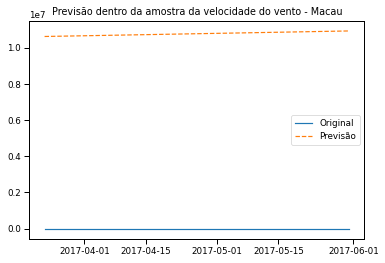

MSE : 23860709041195.02344
RMSE: 4884742.47440
MAE : 3638732.28607
MAPE: 5817915436991.86328


In [11]:
plot_predict_data(data,pred_gs2,start,end)

### Modelos obtidos com [AUTO-ARIMA]

> ORDER (3,0,2) => [TESTE ANTIGO]

In [ ]:
pred_old_aa, model_fit_old_aa = predict_data(data,(3,0,2))

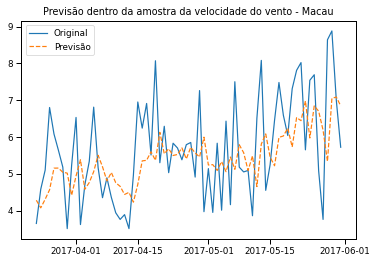

MSE : 1.07112
RMSE: 1.03495
MAE : 0.82306
MAPE: 0.16564


In [ ]:
plot_predict_data(data,pred_old_aa,start,end)

> ORDER (10,0,5)

In [ ]:
pred_aa1, model_fit_aa1 = predict_data(data,(10,0,5))

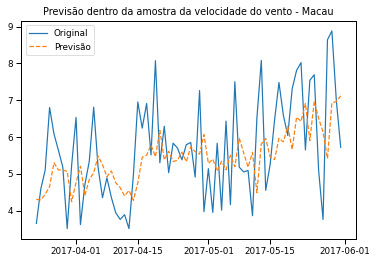

MSE : 1.04977
RMSE: 1.02458
MAE : 0.81377
MAPE: 0.16414


In [ ]:
plot_predict_data(data,pred_aa1,start,end)

COM SAZONALIDADE

> ORDER (3,1,0)(2,1,0)[6]; **RMSE: 1.23853**

> ORDER (3,0,0)(2,0,2)[6]; **RMSE: 1.07488**

> ORDER (4,0,0)(2,0,2)[6]; **RMSE: 1.06858**

> ORDER (5,0,4)(0,0,1)[6]; **RMSE: 1.03406**

> ORDER (1,0,0)(1,0,1)[12]; **RMSE: 1.14759**

> ORDER (10,0,5)(0,0,0)[0]; **RMSE: 1.03265**

> ORDER ARIMA(1,0,0)(2,0,2)[7]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax_model=SARIMAX(df.Velocidade, order=(10,0,5), seasonal_order=(0,0,0,0))
resultado_sarimax = sarimax_model.fit()

In [ ]:
import statsmodels.api as sm
mod = sm.tsa.statespace. SARIMAX (df['Velocidade'],
                                  trend = 'n',
                                  order = (1, 0, 0),
                                  seasonal_order = (2, 0, 2, 7),
                                  enforce_invertibility = False)
resultado_sarimax = mod.fit()
# resultado_sarimax.summary()

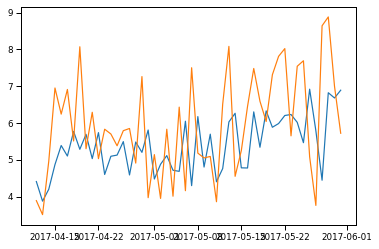

RMSE: 1.13800


In [ ]:
pred = resultado_sarimax.predict()
plt.plot(pred[4850:])
plt.plot(df.Velocidade[4850:])
plt.show()
rmse_sarima = sqrt(mean_squared_error(df.Velocidade.values, pred.values))
print("RMSE: {:.5f}".format(rmse_sarima))

## **Previsão Out Of Sample**

In [ ]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) - set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [ ]:
def forecast_data(data, params, steps):
    model = ARIMA(data, order=params)
    model_fit = model.fit()
    predictios = model_fit.forecast(steps)
    return predictios

In [ ]:
def data_frame(test, pred):
    dataset = DataFrame(test)
    dataset['previsao'] = pred
    dataset.dropna(inplace=True)
    return dataset

In [ ]:
def evaluate_error(orig, pred):
    print("MSE : {:.5f}".format(mean_squared_error(pred.values, orig.values)))
    print("RMSE: {:.5f}".format(np.sqrt(mean_squared_error(pred.values, orig.values))))
    print("MAE : {:.5f}".format(mean_absolute_error(pred.values, orig.values)))
    print("MAPE: {:.5f}".format(mean_absolute_percentage_error(pred.values, orig.values)))

In [ ]:
from pandas.core.frame import DataFrame
import warnings
from math import sqrt
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

def prediction(dataset, params, steps):
    # separa os dados em treino e teste
    x = dataset
    size = int(len(x) - steps)
    train, test = x[0:size], x[size:len(x)]

    prediction = []
    confM=[]
    confm=[]
    history = [x for x in train]
    for t in test.values:
        model = ARIMA(history, order=params).fit()
        y = model.forecast(steps=len(test))
        # y,err,ci = model.forecast(steps=len(test), alpha=0.05)
        # confm.append(ci[0][0])
        # confM.append(ci[0][1])
        prediction.append(y[0])
        history.append(t)
    test_ = DataFrame(test)
    test_['predictions_wf'] = prediction
    print(test_)
    # return test_, confm, confM
    return test_

In [ ]:
def plot_forecast(train, test, pred, length_train):
    plt.plot(train[len(train)-length_train:],color='teal',label='Treino')
    plt.plot(test,color='orangered',label='Teste')
    plt.plot(pred,'--',label='Previsão')
    plt.title("Previsão fora da amostra de vários passos com FORECAST")
    plt.legend()
    plt.show()
    print("MSE : {:.5f}".format(mean_squared_error(pred.values, test.values)))
    print("RMSE: {:.5f}".format(np.sqrt(mean_squared_error(pred.values, test.values))))
    print("MAE : {:.5f}".format(mean_absolute_error(pred.values, test.values)))
    print("MAPE: {:.5f}".format(mean_absolute_percentage_error(pred.values, test.values)))

In [ ]:
# def plot_prediction(train, test_, ci_m, ci_M, start):
def plot_prediction(train, test_, start):
    error = sqrt(mean_squared_error(test_.Velocidade, test_.predictions_wf))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(train[start:], label='Treino', color="teal")
    ax.plot(test_.Velocidade, label='Teste',color="orangered")
    ax.plot(test_.predictions_wf, '--,m', label='Previsão')
    # ax.fill_between(test_.predictions_wf.index,
    #                 ci_m,
    #                 ci_M, color='b', alpha=.15, label='conf. 95%')
    ax.set_title("Previsão da velocidade do vento - Macau")
    ax.set_xlabel('Data')
    ax.set_ylabel('Velocidade')
    plt.suptitle(["RMSE:", round(error,3)])
    plt.legend()
    plt.show()
    print("MSE: " + str(mean_squared_error(test_['predictions_wf'], test_['Velocidade'])))
    print("RMSE: " + str(np.sqrt(mean_squared_error(test_['predictions_wf'], test_['Velocidade']))))
    print("MAE: " + str(mean_absolute_error(test_['predictions_wf'], test_['Velocidade'])))
    print("MAPE: " + str(mean_absolute_percentage_error(test_['predictions_wf'], test_['Velocidade'])))

In [ ]:
train_1step, test_1step = split_dataset(df.Velocidade, 1, True)


BASE DE TREINO
 Data
2017-05-26    5.08
2017-05-27    3.76
2017-05-28    8.64
2017-05-29    8.88
2017-05-30    7.00
Name: Velocidade, dtype: float64

BASE DE TESTE
 Data
2017-05-31    5.72
Name: Velocidade, dtype: float64


### Previsão de 1 passo [Pesquisa em grade]

> ORDER (9,0,7) => Modelo Antigo

In [ ]:
fc_gs = forecast_data(train_1step, (9,0,7),1)
fc_gs

2017-05-31    7.058297
Freq: D, dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_gs)

MSE : 1.79104
RMSE: 1.33830
MAE : 1.33830
MAPE: 0.18961


> ORDER (12,0,11) => [SEM DIFERENCIAÇÃO]

In [ ]:
fc_gs1 = forecast_data(train_1step, (12,0,11),1)
fc_gs1

2017-05-28    5.64294
Freq: D, dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_gs1)

MSE : 8.98237
RMSE: 2.99706
MAE : 2.99706
MAPE: 0.53112


### Previsão de 1 passo [AUTO-ARIMA]



> ORDER (3,0,2) => Teste Antigo

In [ ]:
fc_aa = forecast_data(train_1step, (3,0,2),1)
fc_aa

2017-05-28    5.328057
Freq: D, dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_aa)

MSE : 10.96897
RMSE: 3.31194
MAE : 3.31194
MAPE: 0.62160


> ORDER (10,0,5) => [SEM DIFERENCIAÇÃO]

In [ ]:
fc_aa1 = forecast_data(train_1step,(10,0,5),1)
fc_aa1

2017-05-28    5.366118
Freq: D, dtype: float64

In [ ]:
evaluate_error(test_1step[:1], fc_aa1)

MSE : 10.71830
RMSE: 3.27388
MAE : 3.27388
MAPE: 0.61010


### Previsão de VARIOS passos [Pesquisa em grade]

In [ ]:
train, test = split_dataset(df.Velocidade, 14, False)

BASE DE TREINO:  4886
BASE DE TESTE:   14


> ORDER (12,0,11) => [FORECAST]

In [ ]:
fc_gsN = forecast_data(train, (12,0,11),14)
fc_gsN

2017-05-18    5.991524
2017-05-19    6.132902
2017-05-20    5.755143
2017-05-21    5.975119
2017-05-22    5.759904
2017-05-23    6.106520
2017-05-24    5.742285
2017-05-25    6.061585
2017-05-26    5.629674
2017-05-27    5.932534
2017-05-28    5.893997
2017-05-29    6.116213
2017-05-30    5.722594
2017-05-31    6.053134
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
dataset_gs = data_frame(test, fc_gsN)
dataset_gs.head()

,Velocidade,previsao
Data,,
2017-05-18 00:00:00,6.59,5.991524
2017-05-19 00:00:00,6.04,6.132902
2017-05-20 00:00:00,7.31,5.755143
2017-05-21 00:00:00,7.81,5.975119
2017-05-22 00:00:00,8.02,5.759904


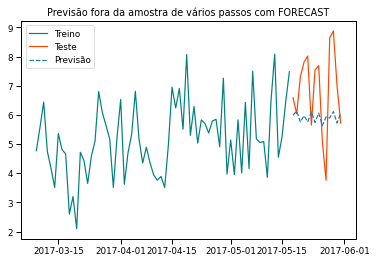

MSE : 2.80678
RMSE: 1.67535
MAE : 1.43331
MAPE: 0.24293


In [ ]:
plot_forecast(train, dataset_gs['Velocidade'],dataset_gs['previsao'], 70)

> ORDER (12,0,11) => [WalkForward]

In [ ]:
order = (12,0,11)
# test_,ci_M,ci_m = prediction(train, order, 7)
# order = (1,0,0)
test_gs = prediction(train, order, 7)

            Velocidade  predictions_wf
Data                                  
2017-05-11        3.86        5.653857
2017-05-12        6.51        4.517941
2017-05-13        8.08        5.951329
2017-05-14        4.55        6.110427
2017-05-15        5.25        5.522102
2017-05-16        6.45        5.586429
2017-05-17        7.48        5.942114


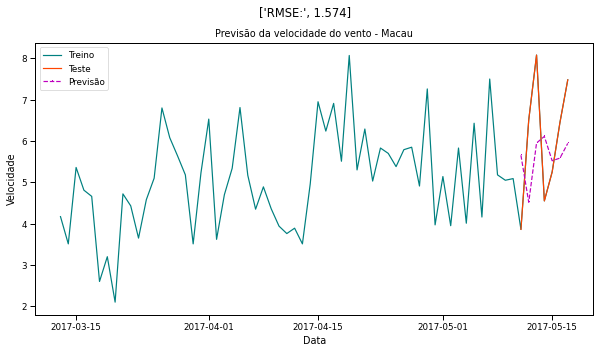

MSE: 2.476754794664854
RMSE: 1.5737708837899036
MAE: 1.4497962285830275
MAPE: 0.26198907305931285


In [ ]:
plot_prediction(train, test_gs, 4820)

### Previsão de VARIOS passos [AUTO-ARIMA]

In [ ]:
train, test = split_dataset(df.Velocidade, 14, False)

BASE DE TREINO:  4886
BASE DE TESTE:   14


> ORDER (10,0,5) => [FORECAST]

In [ ]:
fc_aaN = forecast_data(train, (10,0,5),14)
fc_aaN

2017-05-18    5.882004
2017-05-19    6.063164
2017-05-20    5.604819
2017-05-21    5.901377
2017-05-22    5.633526
2017-05-23    5.803971
2017-05-24    5.456482
2017-05-25    5.962807
2017-05-26    5.548652
2017-05-27    5.870774
2017-05-28    5.701403
2017-05-29    5.918815
2017-05-30    5.583069
2017-05-31    6.022679
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
dataset_aa = data_frame(test, fc_aaN)
dataset_aa.head()

,Velocidade,previsao
Data,,
2017-05-18 00:00:00,6.59,5.882004
2017-05-19 00:00:00,6.04,6.063164
2017-05-20 00:00:00,7.31,5.604819
2017-05-21 00:00:00,7.81,5.901377
2017-05-22 00:00:00,8.02,5.633526


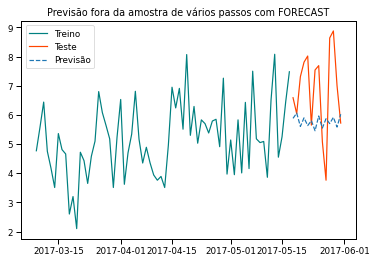

MSE : 3.16241
RMSE: 1.77832
MAE : 1.49250
MAPE: 0.25980


In [ ]:
plot_forecast(train, dataset_aa['Velocidade'],dataset_aa['previsao'], 70)

> ORDER (10,0,5) => [WalkForward]

In [ ]:
order = (10,0,5)
test_aa = prediction(train, order, 7)

            Velocidade  predictions_wf
Data                                  
2017-05-11        3.86        5.573011
2017-05-12        6.51        4.472885
2017-05-13        8.08        5.820312
2017-05-14        4.55        5.933538
2017-05-15        5.25        5.473357
2017-05-16        6.45        5.370210
2017-05-17        7.48        5.971073


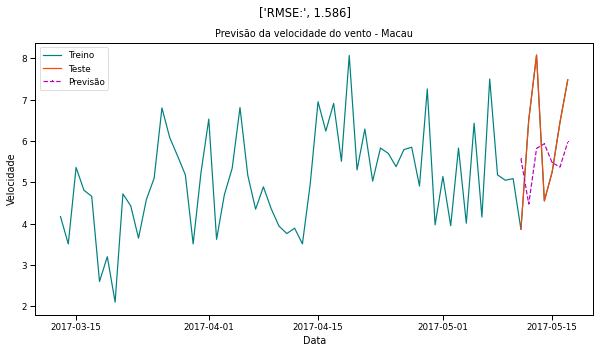

MSE: 2.513900656864057
RMSE: 1.5855285102652859
MAE: 1.457917954887223
MAPE: 0.2684016356044088


In [ ]:
plot_prediction(train, test_aa, 4820)